In [1]:
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Tuple, Union

import IPython.display as ipd
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
plt.style.use("ggplot")

# View Data

In [3]:
@dataclass
class Features:
    sample_rate: int = 22050  # Частота дискретизации аудио сигнала (по умолчанию 22050).
    hop_length: int = 220  # Размер перекрытия во временной области при вычислении спектрограммы.
    n_fft: int = 2048  # Размер окна Фурье при вычислении спектрограммы.
    n_frames_per_example: int = 1  # Количество временных кадров (фреймов) в одном примере при извлечении признаков.

def load_wav(path: Union[str, Path], sample_rate: int) -> np.ndarray:
    """
    Загружает аудиофайл и возвращает сигнал в виде массива numpy.ndarray.

    Args:
        path (Union[str, Path]): Путь к аудиофайлу.
        sample_rate (int): Частота дискретизации.

    Returns:
        np.ndarray: Сигнал аудиофайла.
    """
    waveform, _ = librosa.load(path, sr=sample_rate)
    return waveform

def extract_features(file_path: Union[str, Path], params: Features) -> List[np.ndarray]:
    """
    Извлекает признаки из аудиофайла с использованием заданных параметров.

    Args:
        file_path (Union[str, Path]): Путь к аудиофайлу.
        params (Features): Параметры для извлечения признаков.

    Returns:
        List[np.ndarray]: Список массивов признаков (фреймов).
    """
    waveform = load_wav(file_path, sample_rate=params.sample_rate)

    spectrogram = librosa.feature.melspectrogram(
        y=waveform, n_fft=params.n_fft, hop_length=params.hop_length
    )

    spectrogram = np.log(1e-20 + spectrogram**2)  # Применение логарифма для более равномерной шкалы.

    n_examples = spectrogram.shape[1] // params.n_frames_per_example

    return [
        spectrogram[
            :, i * params.n_frames_per_example : (i + 1) * params.n_frames_per_example
        ].reshape(1, -1)
        for i in range(n_examples)
    ]

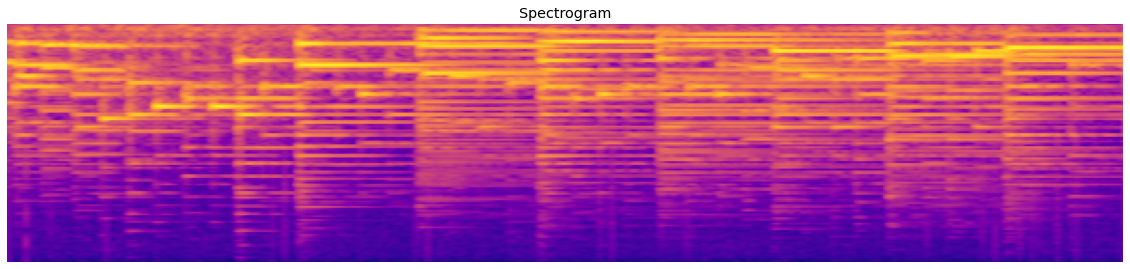

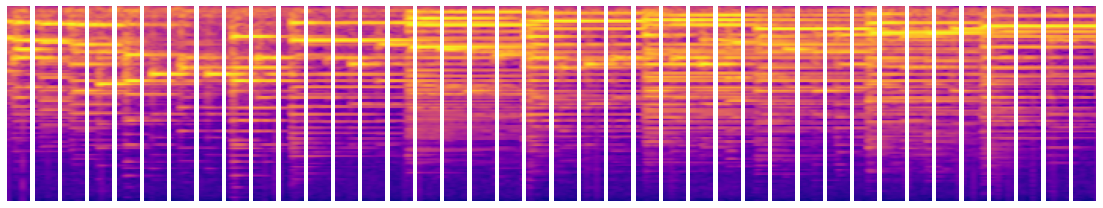

In [14]:
# 1161154212832220511.wav
# 1429195257218202828.wav

PATH = "./train/train/classical/1429195257218202828.wav"
PARAMS = Features(n_frames_per_example=15)

ipd.display(ipd.Audio(PATH))

sample_features = [
    feature.reshape(-1, PARAMS.n_frames_per_example)
    for feature in extract_features(file_path=PATH, params=PARAMS)
]

plt.figure(figsize=(20, 5))
plt.title("Spectrogram")
plt.imshow(np.hstack(sample_features), cmap="plasma")
plt.axis("off")
plt.savefig("spectrogram.png", dpi=200)
plt.show()

plt.figure(figsize=(20, 5))
for i, feature in enumerate(sample_features):
    plt.subplot(1, len(sample_features) + 1, i + 1)
    plt.imshow(feature, cmap="plasma")
    plt.axis("off")
plt.show()

# Prepare Train Dataset

In [4]:
def load_folder_data(
    path: Path, train: bool, params: Features
) -> Tuple[List[List[np.ndarray]], List[List[str]], List[Path]]:
    features: List[List[np.ndarray]] = []
    labels: List[List[str]] = []
    file_names: List[Path] = list(path.rglob("*.wav"))

    for file_path in file_names:
        file_features = extract_features(file_path, params)

        features.append(file_features)

        if train:
            class_name = file_path.parent.name
            labels.append([class_name] * len(file_features))

    return features, labels, file_names

In [5]:
@dataclass
class ExpConfig:
    features: Features = Features(
        sample_rate=22050,
        hop_length=220,
        n_fft=2048,
        n_frames_per_example=1,
    )
    random_state: int = 42
    test_size: float = 0.1
    train_path: Path = Path("./train/train")
    test_path: Path = Path("./test/test")


config = ExpConfig()

In [6]:
class_names = [folder.name for folder in config.train_path.iterdir()]

class_name2id: Dict[str, int] = {
    class_name: class_id for class_id, class_name in enumerate(class_names)
}

features, labels, file_names = load_folder_data(
    path=config.train_path, train=True, params=config.features
)

labels_int: List[List[int]] = [
    [class_name2id[label] for label in label_list] for label_list in labels
]

In [8]:
file_names[:2]

[PosixPath('train/train/pop/8687558074542448474.wav'),
 PosixPath('train/train/pop/5207223688718240848.wav')]

In [7]:
(
    features_train,
    features_test,
    labels_train,
    labels_test,
    files_train,
    files_test,
) = train_test_split(
    features,
    labels_int,
    file_names,
    random_state=config.random_state,
    test_size=config.test_size,
)

In [17]:
# Отменим разбивку на две разные выборки
# features_train = features
# labels_train = labels_int
# files_train = file_names

In [8]:
X_train = np.vstack([feature for feature_list in features_train for feature in feature_list])
y_train = np.array([label for label_list in labels_train for label in label_list])

In [18]:
X_train.shape

(2438084, 128)

In [19]:
%%time

pipe = Pipeline([("scaler", StandardScaler()), ("clf", SGDClassifier(loss="log"))]).fit(
    X_train, y_train
)

/home/timofey/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


CPU times: user 1min 45s, sys: 3.39 s, total: 1min 49s
Wall time: 1min 49s


# Interpretation

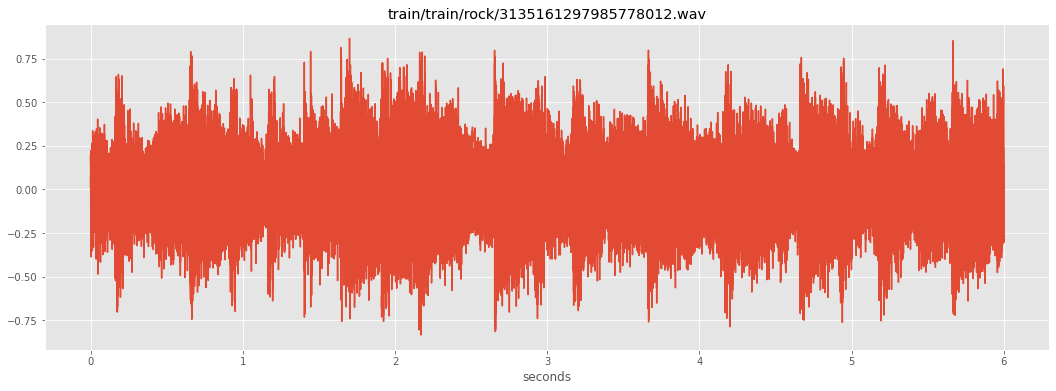

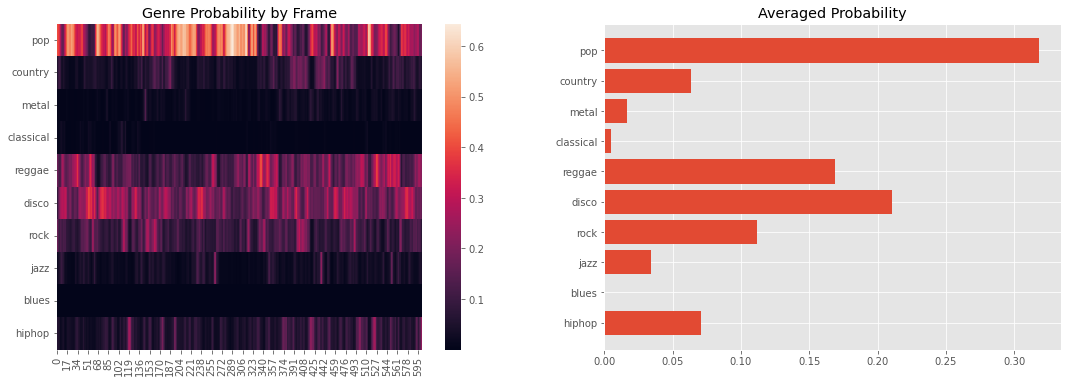

In [20]:
TEST_ID = 892

predictions = pipe.predict_proba(np.vstack(features_train[TEST_ID]))

plt.figure(figsize=(18, 6))
plt.title(files_train[TEST_ID])
wave_form = load_wav(files_train[TEST_ID], sample_rate=config.features.sample_rate)
time_axis = [x / config.features.sample_rate for x in range(wave_form.size)]
plt.plot(time_axis, wave_form)
plt.xlabel("seconds")
plt.show()

ipd.display(ipd.Audio(files_train[TEST_ID]))
plt.figure(figsize=(18, 6))
plt.subplot(121)
plt.title("Genre Probability by Frame")
sns.heatmap(predictions.T, yticklabels=class_names)

plt.subplot(122)
plt.title("Averaged Probability")
plt.barh(class_names, predictions.mean(0))
plt.gca().invert_yaxis()
plt.show()

## Confusion matrix

In [9]:
def plot_conf_matrix(
    y_test: np.ndarray, y_pred: np.ndarray, class_names: List[str], annot: bool = False
) -> None:
    plt.figure(figsize=(8, 6))
    plt.title(f"Accuracy: {(y_test == y_pred).mean():.2f}")
    sns.heatmap(
        confusion_matrix(y_test, y_pred),
        xticklabels=class_names,
        yticklabels=class_names,
        linewidths=0.5,
        annot=annot,
    )
    plt.show()

### by frame

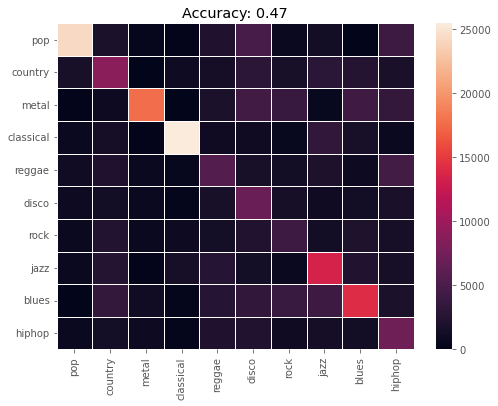

In [22]:
X_test = np.vstack(
    [feature for feature_list in features_test for feature in feature_list]
)

y_test = np.array([label for label_list in labels_test for label in label_list])

y_pred = pipe.predict(X_test)

plot_conf_matrix(y_pred, y_test, class_names)

### by record

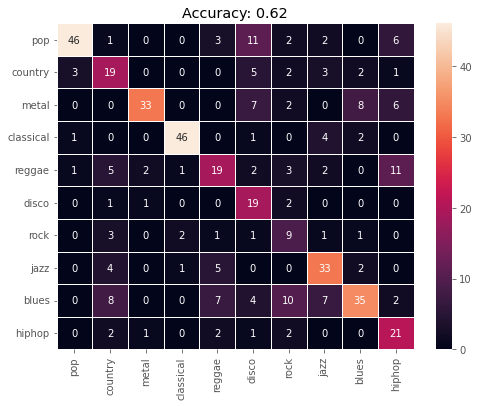

In [23]:
y_pred = np.array(
    [
        pipe.predict_proba(np.vstack(feature_list)).mean(0).argmax()
        for feature_list in features_test
    ]
)

y_test = np.array([label_list[0] for label_list in labels_test])

plot_conf_matrix(y_pred, y_test, class_names, annot=True)

# Test

In [10]:
test_features, _, test_pathes = load_folder_data(
    config.test_path, train=False, params=config.features
)

In [19]:
# Результат 0.52
# X_test = np.vstack(
#     [feature_list[0] for feature_list in test_features]
# )

# predictions = [class_names[prediction] for prediction in pipe.predict(X_test)]

In [15]:
predictions = [
    class_names[pipe.predict_proba(np.vstack(test_feature)).mean(0).argmax()]
    for test_feature in test_features
]

In [22]:
# Дал результат такой же, как и by_frame - 0.52
def get_longest_sequence(predictions):
    max_sequence_length = 0
    current_sequence_length = 0
    start_index = 0
    max_sequence_start_index = 0
    
    for i in range(1, len(predictions)):
        if predictions[i] == predictions[i-1]:
            current_sequence_length += 1
        else:
            if current_sequence_length > max_sequence_length:
                max_sequence_length = current_sequence_length
                max_sequence_start_index = start_index
            current_sequence_length = 0
            start_index = i
    
    # Check if the last sequence is the longest
    if current_sequence_length > max_sequence_length:
        max_sequence_length = current_sequence_length
        max_sequence_start_index = start_index
    
    return max_sequence_start_index, max_sequence_start_index + max_sequence_length


final_predictions = []

for test_feature in test_features:
    probabilities = pipe.predict_proba(np.vstack(test_feature))
    predictions = [class_names[p.argmax()] for p in probabilities]
    
    start_index, end_index = get_longest_sequence(predictions)
    final_prediction = predictions[start_index]
    final_predictions.append(final_prediction)

# Save predictions to CSV
df = pd.DataFrame({"index": [test_wav_path.name for test_wav_path in test_pathes], "genre": final_predictions})
df.to_csv("submit_longest_sequence.csv", index=False)


In [22]:
# Взвешенное голосование. Дало результат 0.51, еще хуже
final_predictions = []

for test_feature in test_features:
    probabilities = pipe.predict_proba(np.vstack(test_feature))
    predictions = [class_names[p.argmax()] for p in probabilities]
    
    start_index, end_index = get_longest_sequence(predictions)
    final_prediction = max(set(predictions[start_index:end_index]), key=predictions[start_index:end_index].count)
    final_predictions.append(final_prediction)

# Save predictions to CSV
df = pd.DataFrame({"index": [test_wav_path.name for test_wav_path in test_pathes], "genre": final_predictions})
df.to_csv("submit_weighted_vote.csv", index=False)


In [16]:
(
    pd.DataFrame(
        {
            "index": [
                test_wav_path.name for test_wav_path in config.test_path.iterdir()
            ],
            "genre": predictions,
        }
    ).to_csv("submit_all_train.csv", index=False)
)

## Попробуем изменить Пайплайн

In [25]:
# # Больше часа обучалась, скипнул
# from sklearn.ensemble import GradientBoostingClassifier

# pipe = Pipeline([
#     ("scaler", StandardScaler()), 
#     ("clf", GradientBoostingClassifier())
# ]).fit(X_train, y_train)

In [12]:
# # Больше 20 min обучалась, скипнул
# from sklearn.ensemble import RandomForestClassifier

# # Создание пайплайна с RandomForestClassifier
# pipe_rf = Pipeline([
#     ("scaler", StandardScaler()),
#     ("clf", RandomForestClassifier())
# ]).fit(X_train, y_train)

In [37]:
## 0.54 score
# from sklearn.dummy import DummyClassifier

# # Создание пайплайна с DummyClassifier и "rescoring"
# pipe_dummy = Pipeline([
#     ("scaler", StandardScaler()),
#     ("clf", DummyClassifier(strategy="stratified"))
# ]).fit(X_train, y_train)

# # Выполнение "rescoring" для выбора наиболее частого предсказания в последовательностях
# final_predictions_dummy = []

# for test_feature in test_features:
#     probabilities = pipe_dummy.predict_proba(np.vstack(test_feature))
#     predictions = [class_names[p.argmax()] for p in probabilities]
    
#     start_index, end_index = get_longest_sequence(predictions)
#     final_prediction = predictions[start_index]
#     final_predictions_dummy.append(final_prediction)

# # Сохранение предсказаний в CSV файл
# df_dummy = pd.DataFrame({"index": [test_wav_path.name for test_wav_path in test_pathes], "genre": final_predictions_dummy})
# df_dummy.to_csv("submit_dummy.csv", index=False)

In [10]:
# Крашнулась
# from sklearn.linear_model import LogisticRegression

# # Создание пайплайна с логистической регрессией и StandardScaler
# pipe_lr = Pipeline([
#     ("scaler", StandardScaler()),
#     ("clf", LogisticRegression())
# ]).fit(X_train, y_train)

: 

: 

In [12]:
# Просто сразу крашится
from catboost import CatBoostClassifier

# Создание пайплайна CatBoostClassifier
pipe_catboost = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", CatBoostClassifier())
]).fit(X_train, y_train)

Learning rate set to 0.117778
0:	learn: 2.1661381	total: 11.5s	remaining: 3h 11m 26s
1:	learn: 2.0773908	total: 22.4s	remaining: 3h 6m 37s
2:	learn: 2.0120597	total: 35.2s	remaining: 3h 14m 42s
3:	learn: 1.9573224	total: 47.4s	remaining: 3h 16m 31s
4:	learn: 1.9108775	total: 58.5s	remaining: 3h 13m 54s
5:	learn: 1.8740395	total: 1m 10s	remaining: 3h 13m 37s
6:	learn: 1.8392829	total: 1m 22s	remaining: 3h 14m 49s
7:	learn: 1.8137889	total: 1m 33s	remaining: 3h 12m 56s
8:	learn: 1.7873669	total: 1m 45s	remaining: 3h 12m 43s
9:	learn: 1.7660523	total: 1m 56s	remaining: 3h 12m 34s
10:	learn: 1.7463291	total: 2m 8s	remaining: 3h 12m 52s
11:	learn: 1.7300917	total: 2m 19s	remaining: 3h 11m 55s
12:	learn: 1.7154846	total: 2m 31s	remaining: 3h 11m 50s
13:	learn: 1.7024082	total: 2m 42s	remaining: 3h 10m 52s
14:	learn: 1.6859222	total: 2m 54s	remaining: 3h 10m 38s
15:	learn: 1.6736958	total: 3m 5s	remaining: 3h 10m 9s
16:	learn: 1.6626826	total: 3m 17s	remaining: 3h 10m
17:	learn: 1.6524697	tot

In [15]:
import joblib
joblib.dump(pipe_catboost, 'models/catboost_model.pkl')
# Загрузка модели из файла
# pipe_catboost = joblib.load('models/catboost_model.pkl')

['models/catboost_model.pkl']

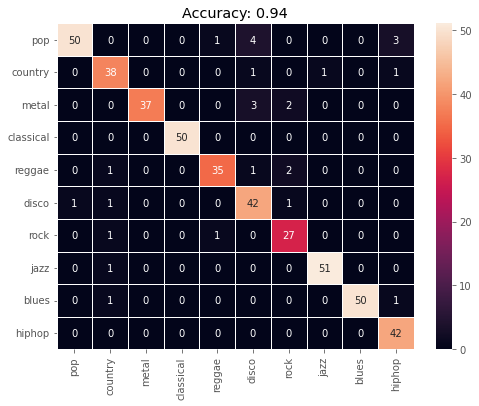

In [16]:
y_pred = np.array(
    [
        pipe_catboost.predict_proba(np.vstack(feature_list)).mean(0).argmax()
        for feature_list in features_test
    ]
)

y_test = np.array([label_list[0] for label_list in labels_test])

plot_conf_matrix(y_pred, y_test, class_names, annot=True)

In [26]:
# Обучалась 9 минут, дала скор 0.74 
from lightgbm import LGBMClassifier
model = LGBMClassifier(random_state = config.random_state, max_depth=-1, class_weight = 'balanced', n_jobs=-1, n_estimators=100)
#model = SGDClassifier(loss="log_loss",class_weight = 'balanced', n_jobs=-1,random_state=42)
pipe_lgbm = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", model)
]).fit(X_train, y_train)

In [ ]:
import joblib
joblib.dump(pipe_lgbm, 'models/lgbm_model.pkl')

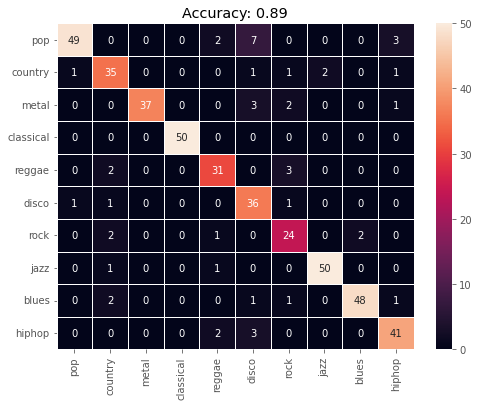

In [28]:
y_pred = np.array(
    [
        pipe_lgbm.predict_proba(np.vstack(feature_list)).mean(0).argmax()
        for feature_list in features_test
    ]
)

y_test = np.array([label_list[0] for label_list in labels_test])

plot_conf_matrix(y_pred, y_test, class_names, annot=True)

In [ ]:
# # Обучалась 55 минут, крашнулась 
# from xgboost import XGBClassifier
# model = XGBClassifier(random_state = config.random_state,  n_jobs=-1)

# pipe_xgb = Pipeline([
#     ("scaler", StandardScaler()),
#     ("clf", model)
# ]).fit(X_train, y_train)

: 

: 

In [18]:
final_pipe = pipe_catboost

In [21]:
predictions = [
    class_names[final_pipe.predict_proba(np.vstack(test_feature)).mean(0).argmax()]
    for test_feature in test_features
]

# Save predictions to CSV
df = pd.DataFrame({"index": [test_wav_path.name for test_wav_path in test_pathes], "genre": predictions})
df.to_csv("submit_catboost.csv", index=False)